# Modelling the glitch

With `asterion.GlitchModel`, you can model the helium-II ionization and base of the convective zone glitches given radial mode frequencies. This can be done with modelled or observed modes (with and without observational uncertainty). This notebook will go through both situations.

In [9]:
import numpy as np
import pandas as pd

import asterion as ast
from asterion import (GlitchModel, HeGlitchFunction, CZGlitchFunction, 
                      AsyFunction, Inference)

## Data

Import stellar evolutionary track.

In [10]:
track = pd.read_csv('data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


Choose a star from the evolutionary track.

In [11]:
profile = track.loc[1008]

Extract modes from star.

In [12]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 551.94 muHz
delta_nu ~ 35.2 muHz


In [13]:
n_max = nu_max_sca / delta_nu_fit - 1.
n_max

14.68073766060638

In [14]:
n_max = int(nu_max_sca / delta_nu_fit - 1.)

n = np.arange(n_max - 7, n_max + 7)
nu_index = [f'nu_0_{i}' for i in n]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

Get global asteroseismic parameters.

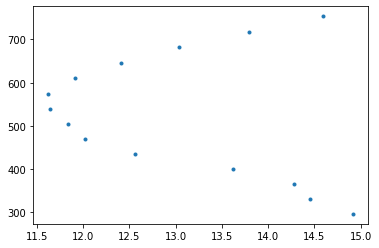

In [15]:
import matplotlib.pyplot as plt

ax = plt.gca()
ax.plot(nu%delta_nu_fit, nu, '.');

## Model without observational error

We can create our model like this. We need to give it a prior for `delta_nu` and `nu_max`. Optionally, we can give it a prior for asymptotic fit parameters `alpha` and `epsilon`, but by default these are fairly uninformative.

In [16]:
delta_nu = (delta_nu_fit, 0.5)
nu_max = (nu_max_sca, 0.05*nu_max_sca)
teff = (4500., 500.)

In [18]:
from asterion import TauPrior
from jax import random

key = random.PRNGKey(0)
prior = TauPrior(nu_max, teff)
log_tau_he, log_tau_cz = prior.condition(key, kind='optimized', num_samples=1000)


INFO[2022-02-11 13:37:52,451]: Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
INFO[2022-02-11 13:37:52,452]: Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-02-11 13:37:52,454]: Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [19]:
background = AsyFunction(delta_nu)
he_glitch = HeGlitchFunction(nu_max, log_tau_he)
cz_glitch = CZGlitchFunction(nu_max, log_tau_cz)

In [21]:
model = GlitchModel(n, background, he_glitch, cz_glitch)

What are our model arguments? We can check the docs for the `__call__` method of `model`. 

### Inference

We setup an inference class with the model and can give it number of warmup steps and samples. The seed is required for reproducibility.

In [23]:
infer = Inference(model, nu=nu, seed=42)

/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:302: UserWarning: Parameter 'phi_he' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \
/Users/alyttle/Repos/alexlyttle/asterion/asterion/inference.py:302: UserWarning: Parameter 'phi_cz' has circular-like support but the distribution is not circular. Consider changing its distribution to numpyro.distributions.VonMises for better performance during MCMC.
  warnings.warn(f"Parameter \'{value['name']}\' has circular-like " + \


#### Prior predictive check

We should do a prior predictive check to see if our model makes sense.

In [24]:
infer.prior_predictive()

This plot shows the prior for `nu` with the dot representing the observed value. It looks good.

In [25]:
data = infer.get_data()
data

Inference data with groups:
	> prior_predictive
	> observed_data
	> constant_data

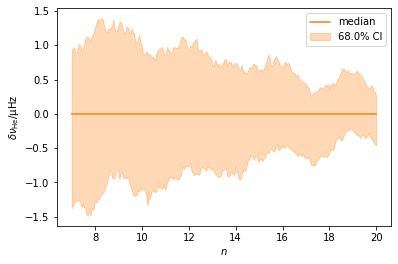

In [26]:
ast.plot_glitch(data, group='prior');

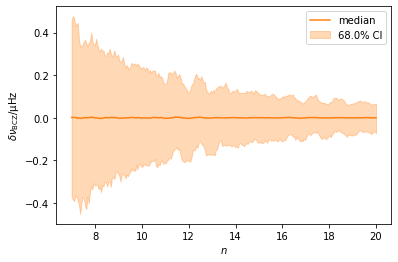

In [27]:
ast.plot_glitch(data, group='prior', kind='CZ');

#### Sample posterior

We can sample from the posterior using one of two methods, `'nested'` or `'mcmc'`. Nested sampling is better suited to multi-modal solutions over MCMC. Since we are fitting sinusoidal functions, there may be cases where one or more periods fit the data, leading to instability during MCMC. Also, the glitch phase term $\phi$ is circular, which can make it difficult to deal with the gradient at $\pm\pi$ for gradient-based MCMC sampling methods. Therefore, we recommend using the nested sampling method, although note that the package on which is is based, '`jaxns`' is still in early development.

If you want to sample using MCMC, follow the advice of the warning when initialising `Inference` and modify the distributions for $\phi$ like so,

```python
import numpyro.distributions as dist
he_glitch.phi = dist.VonMises(0.0, 0.1)
cz_glitch.phi = dist.VonMises(0.0, 0.1)
```

In [28]:
infer.sample(
    num_samples=2000,
    method='nested',  # default method 
    nested_kwargs={
        'num_live_points': 150,  # Should be ~ 50 per expected posterior mode
        'depth': 7,
    }
)

In [29]:
infer.posterior_predictive()

When use nested sampling the inference data may produce some warnings. This is because we save the weighted samples in a custom group which is not defined by `arviz`. You may ignore these.

In [30]:
data = infer.get_data()
data

/Users/alyttle/.pyenv/versions/3.9.9/envs/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/3.9.9/envs/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

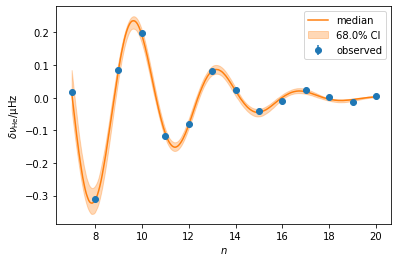

In [31]:
ast.plot_glitch(data);

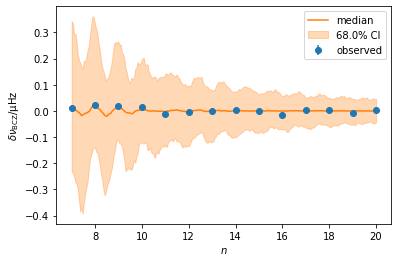

In [32]:
ast.plot_glitch(data, kind='CZ');

To quickly view the parameter names you can inspect `data` or just call the following.

In [34]:
ast.get_var_names(data)

['a_cz',
 'a_he',
 'b_he',
 'delta_nu',
 'dnu_cz',
 'dnu_he',
 'epsilon',
 'log_a_cz',
 'log_a_he',
 'log_b_he',
 'log_tau_cz',
 'log_tau_he',
 'noise',
 'nu_bkg',
 'phi_cz',
 'phi_he',
 'tau_cz',
 'tau_he']

Let's just plot glitch parameter names.

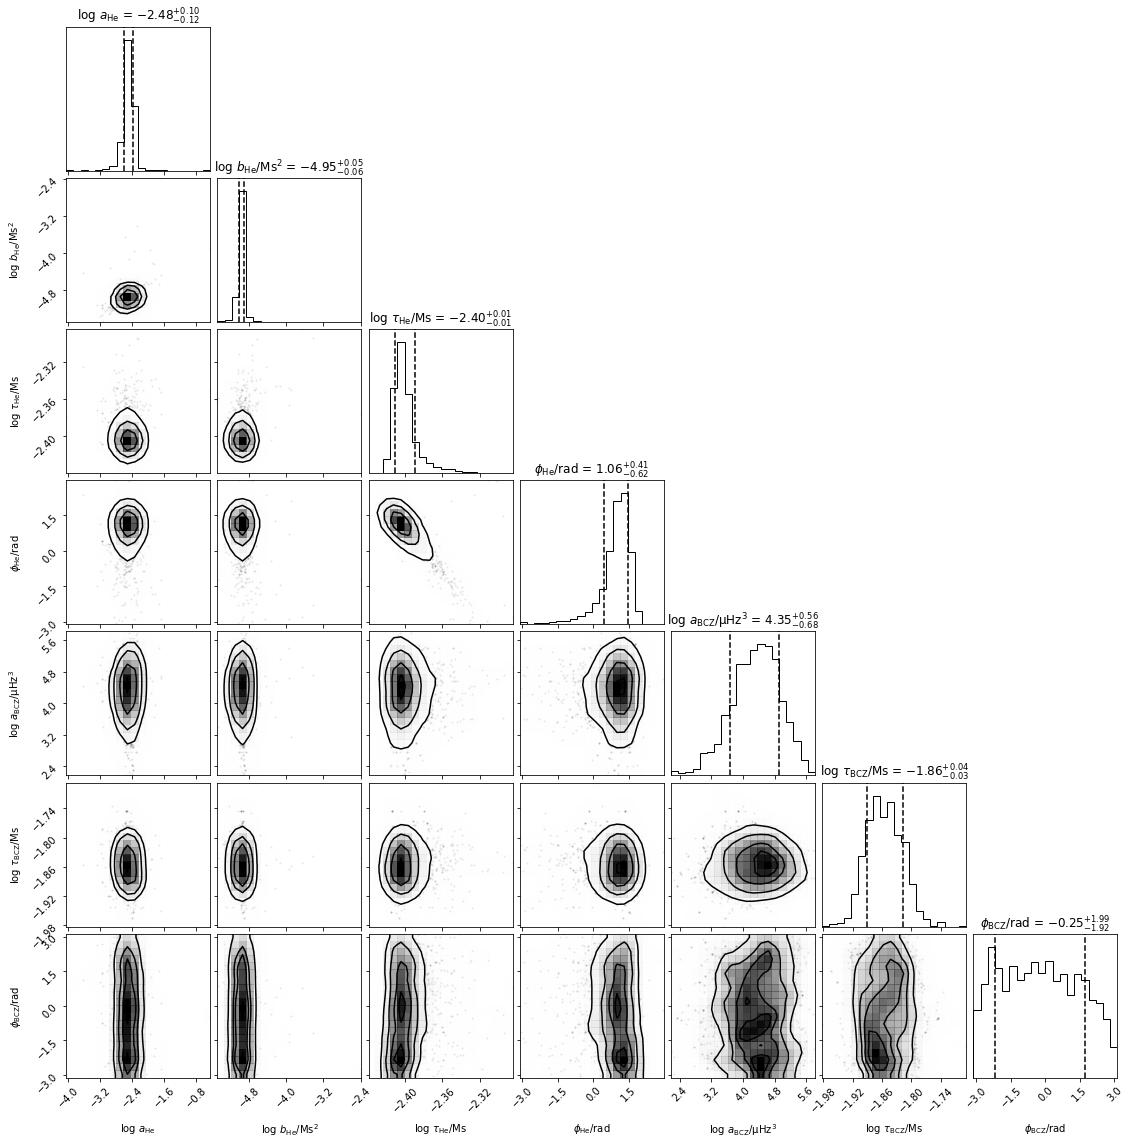

In [33]:
glitch_names = ['log_a_he', 'log_b_he', 'log_tau_he', 'phi_he', 'log_a_cz', 'log_tau_cz', 'phi_cz']
ast.plot_corner(data, var_names=glitch_names);

How about the background parameters and noise.

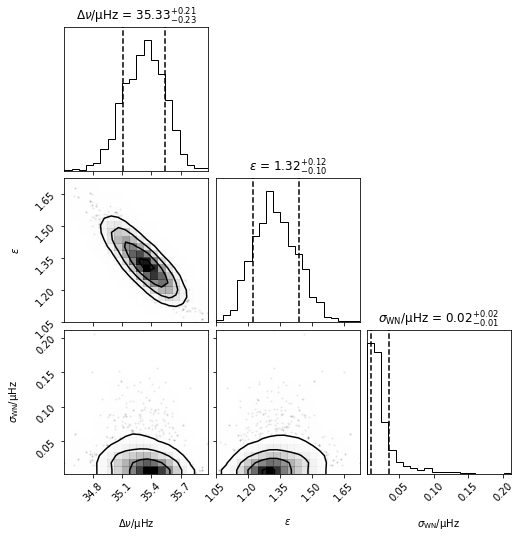

In [35]:
ast.plot_corner(data, var_names=['delta_nu', 'epsilon', 'noise']);

We can even plot from the posterior precictive, that is to say the predicted values for a given variable. E.g. `'nu'` for the first 5 radial orders.

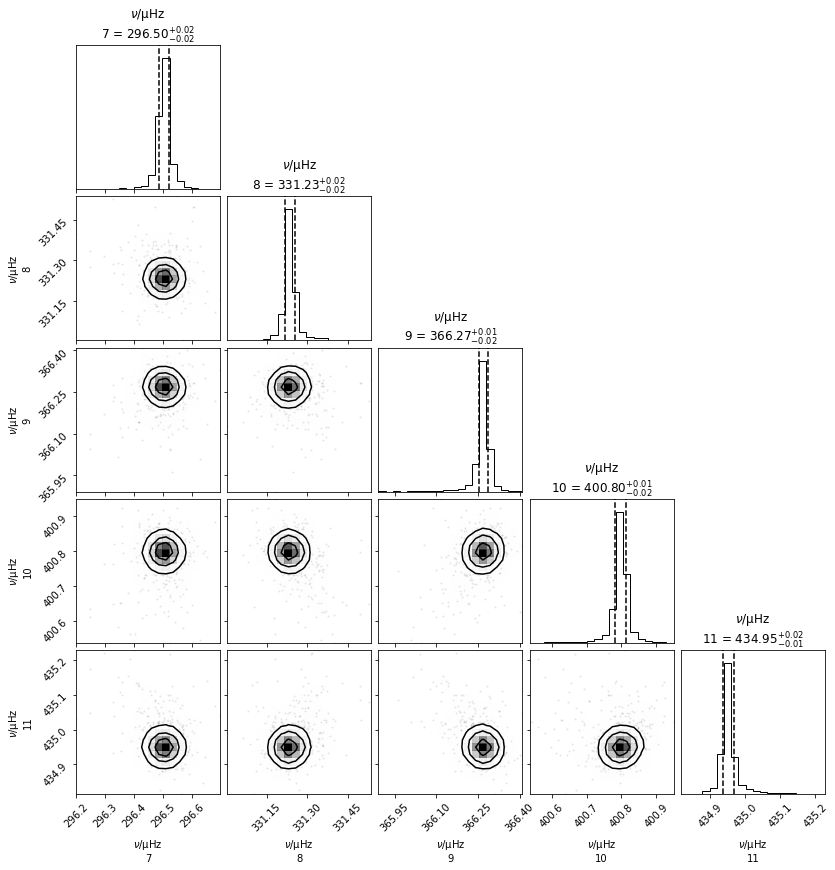

In [36]:
ast.plot_corner(data, group='posterior_predictive', var_names=['nu'], coords={'n': n[:5]});

You can also pass data to `arviz` functions. Note, if using nested sampling, some functions like `traceplot` or `rhat` are useless since they are tailored to MCMC methods. 

Below, we plot the prior predictive and the posterior for the glitch parameters. We can use `asterion.get_labeller` to get an arviz labeller to replace variable names with their symbols and units.

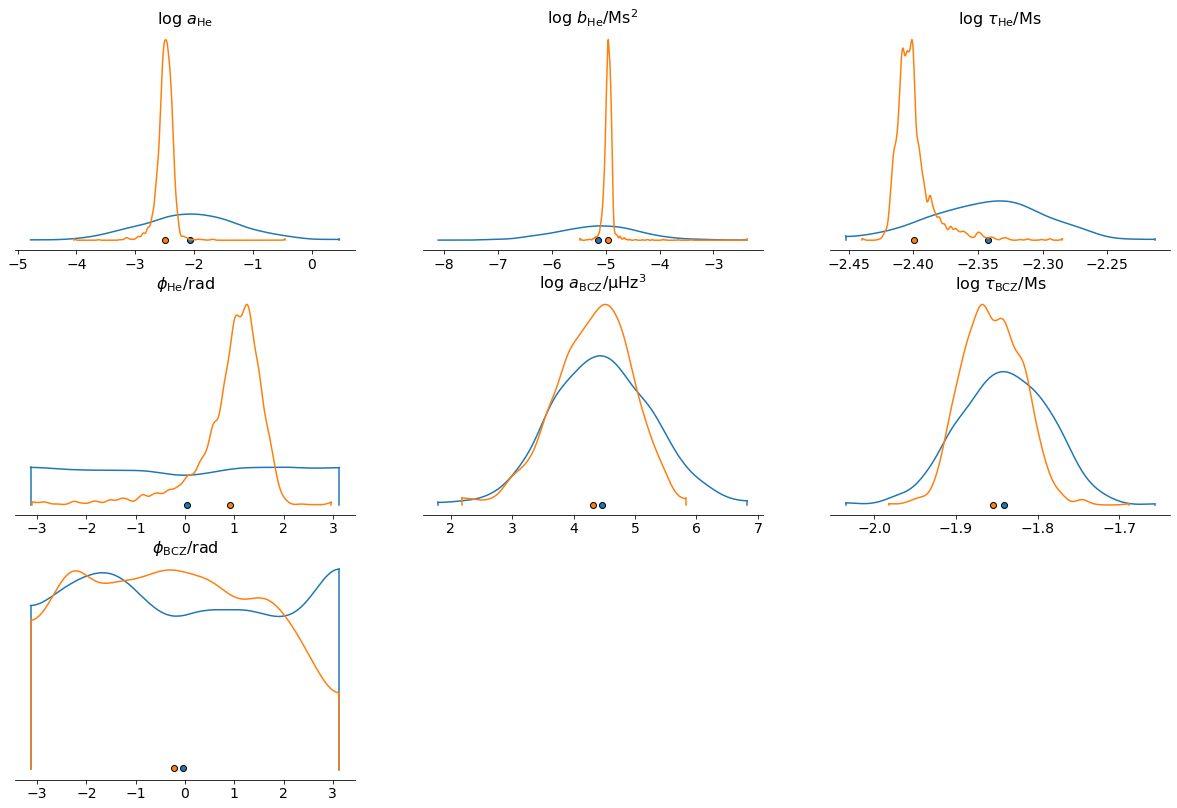

In [38]:
import arviz as az

labeller = ast.get_labeller(data, var_names=glitch_names)

ax = az.plot_density(data, group='prior_predictive', colors='C0', 
                     var_names=glitch_names, hdi_prob=1., labeller=labeller)
ax = az.plot_density(data, group='posterior', colors='C1', 
                     var_names=glitch_names, hdi_prob=1., labeller=labeller,
                     ax=ax)

In [39]:
data.to_netcdf('data/inference_data.nc')

'data/inference_data.nc'

### Tables

You can generate a table for the results data for a chosen data dimension(s). E.g. all the data without any dimensions can be obtained like so. By default, the values are rounded using the standard error on the mean as a guide, although you may pass your own dictionary of formatting rules.

In [60]:
ast.get_table(data, dims=())

,a_cz,a_he,b_he,delta_nu,epsilon,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_he,tau_cz,tau_he
metric,,,,,,,,,,,,,,,
mean,46700.0,0.0035,0.000014,35.323,1.329,4.31,-2.495,-4.951,-1.8550,-2.3997,0.0239,-0.22,0.91,0.01401,0.003986
sd,66800.0,0.0079,0.000093,0.213,0.103,0.61,0.149,0.116,0.0360,0.0153,0.0223,1.67,0.70,0.00117,0.000147
16th,4700.0,0.0025,0.000010,35.106,1.223,3.68,-2.599,-5.011,-1.8915,-2.4111,0.0085,-2.18,0.44,0.01284,0.003881
50th,22500.0,0.0033,0.000011,35.332,1.322,4.35,-2.484,-4.953,-1.8566,-2.4029,0.0173,-0.25,1.06,0.01391,0.003954
84th,81900.0,0.0041,0.000013,35.538,1.437,4.91,-2.384,-4.899,-1.8170,-2.3899,0.0356,1.74,1.46,0.01524,0.004074


You can also format the table using astropy, which makes use of quantity unit metadata.

In [61]:
ast.get_table(data, dims=(), fmt='astropy')

metric,a_cz,a_he,b_he,delta_nu,epsilon,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_he,tau_cz,tau_he
,uHz3,,Ms2,uHz,,dex(uHz3),dex,dex(Ms2),dex(Ms),dex(Ms),uHz,rad,rad,Ms,Ms
str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
mean,46700.0,0.0035,1.4e-05,35.323,1.329,4.31,-2.495,-4.951,-1.855,-2.3997,0.0239,-0.22,0.91,0.01401,0.003986
sd,66800.0,0.0079,9.3e-05,0.213,0.103,0.61,0.149,0.116,0.036,0.0153,0.0223,1.67,0.7,0.00117,0.000147
16th,4700.0,0.0025,1e-05,35.106,1.223,3.68,-2.599,-5.011,-1.8915,-2.4111,0.0085,-2.18,0.44,0.01284,0.003881
50th,22500.0,0.0033,1.1e-05,35.332,1.322,4.35,-2.484,-4.953,-1.8566,-2.4029,0.0173,-0.25,1.06,0.01391,0.003954
84th,81900.0,0.0041,1.3e-05,35.538,1.437,4.91,-2.384,-4.899,-1.817,-2.3899,0.0356,1.74,1.46,0.01524,0.004074


Or, we may want a table for all variables with the dimension $n$ (i.e. the individual modes) and from the posterior predictive group (to include the predicted frequencies for $n$).

In [64]:
ast.get_table(data, dims=('n',), group='posterior_predictive')

dnu_cz   dnu_he        nu  nu_bkg      nu_obs
metric n                                                
mean   7    0.071  0.02305  296.5026  294.19  296.502446
       8    0.102 -0.30697  331.2372  329.51  331.236391
       9    0.087  0.08322  366.2660  364.84  366.268988
       10   0.051  0.18423  400.7964  400.16  400.805250
       11   0.016 -0.10834  434.9544  435.48  434.940915
...           ...      ...       ...     ...         ...
84th   16   0.059  0.01008  610.3192  613.59  610.289730
       17   0.049  0.02637  645.9983  648.97  645.989507
       18   0.052 -0.00162  681.8219  684.42  681.815369
       19   0.048 -0.00271  717.7884  719.85  717.763513
       20   0.045  0.00526  753.7832  755.29  753.768135

[70 rows x 5 columns]

## Model with observational error

Synthesise observational error.

In [40]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [41]:
rng = np.random.default_rng(42)

In [42]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [43]:
nu_obs = add_noise(rng, nu, nu_err)

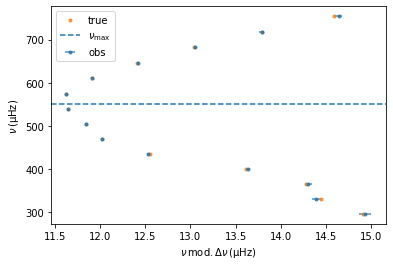

In [49]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_mod_obs, nu_obs, xerr=nu_err, fmt='.', label='obs', alpha=0.8)
ax.plot(nu_mod, nu, '.', label='true', alpha=0.8)

ax.axhline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_xlabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_ylabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [50]:
infer.nu_err = nu_err

In [51]:
infer.sample(
    num_samples=2000,
    method='nested',  # default method 
    nested_kwargs={
        'num_live_points': 150,  # Should be ~ 50 per expected posterior mode
        'depth': 7,
    }
)

In [52]:
infer.posterior_predictive()

In [65]:
data = infer.get_data()
data

/Users/alyttle/.pyenv/versions/3.9.9/envs/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1333: UserWarning: The group weighted_posterior is not defined in the InferenceData scheme
  warnings.warn(
/Users/alyttle/.pyenv/versions/3.9.9/envs/asterion/lib/python3.9/site-packages/arviz/data/inference_data.py:1344: UserWarning: the default dims 'chain' and 'draw' will be added automatically
  warnings.warn(


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> weighted_posterior

In [70]:
dnu_pred = data.posterior_predictive['dnu_he_pred']
dnu_quant = dnu_pred.quantile([.025, .16, .84, .975], dim=('chain', 'draw'))

In [72]:
dnu_quant[0]

<xarray.DataArray 'dnu_he_pred' (n_pred: 250)>
array([-1.23355022e-01, -1.56539068e-01, -1.85969966e-01, -2.18800006e-01,
       -2.48050909e-01, -2.76473526e-01, -3.00920234e-01, -3.25701291e-01,
       -3.41276343e-01, -3.57956918e-01, -3.72991896e-01, -3.87891699e-01,
       -3.98617029e-01, -4.06520183e-01, -4.14034283e-01, -4.17302865e-01,
       -4.18853349e-01, -4.17031747e-01, -4.13887356e-01, -4.05874870e-01,
       -3.95330701e-01, -3.81714469e-01, -3.70061780e-01, -3.56379382e-01,
       -3.39574776e-01, -3.21097683e-01, -2.99492039e-01, -2.80566150e-01,
       -2.60650261e-01, -2.39958543e-01, -2.15187666e-01, -1.94755762e-01,
       -1.70623105e-01, -1.49197464e-01, -1.21365036e-01, -1.01172562e-01,
       -7.45916205e-02, -5.30797910e-02, -3.90741172e-02, -2.26719157e-02,
       -8.75120543e-03, -2.56125508e-03, -7.15400912e-05, -1.40612138e-09,
        4.93420089e-32,  1.30132549e-16,  4.79447574e-14,  6.94776805e-06,
        6.91256167e-06,  5.78961714e-06,  3.79365437e-06,  1.10805788e-06,
        6.02931942e-06,  5.73962985e-06,  5.14704088e-06,  3.14277674e-07,
        6.77445214e-12,  6.70365462e-18, -6.56315582e-22, -4.02695920e-08,
       -8.07147539e-07, -1.87811216e-05, -2.87717375e-03, -7.66375225e-03,
       -1.49779187e-02, -2.17049593e-02, -3.44383815e-02, -4.01111041e-02,
       -5.33676227e-02, -6.48835077e-02, -7.64119562e-02, -8.70284679e-02,
       -9.67136896e-02, -1.08662981e-01, -1.21188296e-01, -1.32343941e-01,
       -1.42781699e-01, -1.50940171e-01, -1.59348544e-01, -1.66435425e-01,
...
       -1.06663632e-02, -7.28394837e-03, -4.17590658e-03, -1.54322722e-03,
       -5.42098742e-05, -3.81771546e-08, -1.69252963e-09, -8.62986343e-09,
       -2.79975398e-08, -6.60178471e-06, -1.95999098e-05, -1.83598177e-05,
       -1.17412040e-04, -3.02521985e-04, -4.21453607e-04, -6.49679974e-04,
       -9.19792956e-04, -1.63579209e-03, -2.13810510e-03, -2.74973445e-03,
       -3.34128786e-03, -4.26455987e-03, -5.78557948e-03, -6.57893933e-03,
       -7.01642024e-03, -8.12065167e-03, -9.17488794e-03, -1.10015771e-02,
       -1.21863589e-02, -1.33614985e-02, -1.51109225e-02, -1.59332696e-02,
       -1.70798567e-02, -1.91025129e-02, -1.92629382e-02, -2.09043334e-02,
       -2.14781324e-02, -2.14882736e-02, -2.22143014e-02, -2.19663836e-02,
       -2.25755963e-02, -2.35119660e-02, -2.50850603e-02, -2.55525492e-02,
       -2.49390834e-02, -2.53170714e-02, -2.47923563e-02, -2.46851343e-02,
       -2.44952490e-02, -2.39395985e-02, -2.33991862e-02, -2.28175663e-02,
       -2.14737063e-02, -1.96427389e-02, -1.90663644e-02, -1.76261570e-02,
       -1.59510463e-02, -1.50534347e-02, -1.33792520e-02, -1.25550546e-02,
       -1.16461979e-02, -1.07383165e-02, -9.71571891e-03, -8.59378207e-03,
       -7.47743383e-03, -6.52530732e-03, -5.73654172e-03, -4.85196214e-03,
       -4.12828871e-03, -3.31351668e-03, -2.52722732e-03, -1.86491748e-03,
       -1.26170772e-03, -9.21139921e-04, -4.89672663e-04, -3.10626537e-04,
       -2.11583024e-04, -2.62241665e-04])
Coordinates:
  * n_pred    (n_pred) float64 7.0 7.052 7.104 7.157 ... 19.84 19.9 19.95 20.0
    quantile  float64 0.025

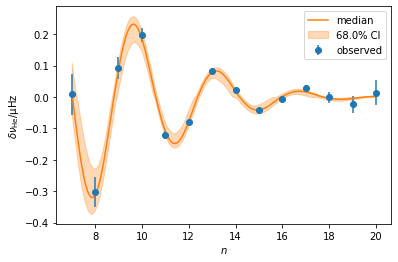

In [80]:
ast.plot_glitch(data, quantiles=[.16, .84]);

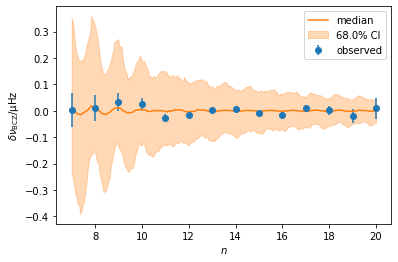

In [56]:
ast.plot_glitch(data, kind='CZ');

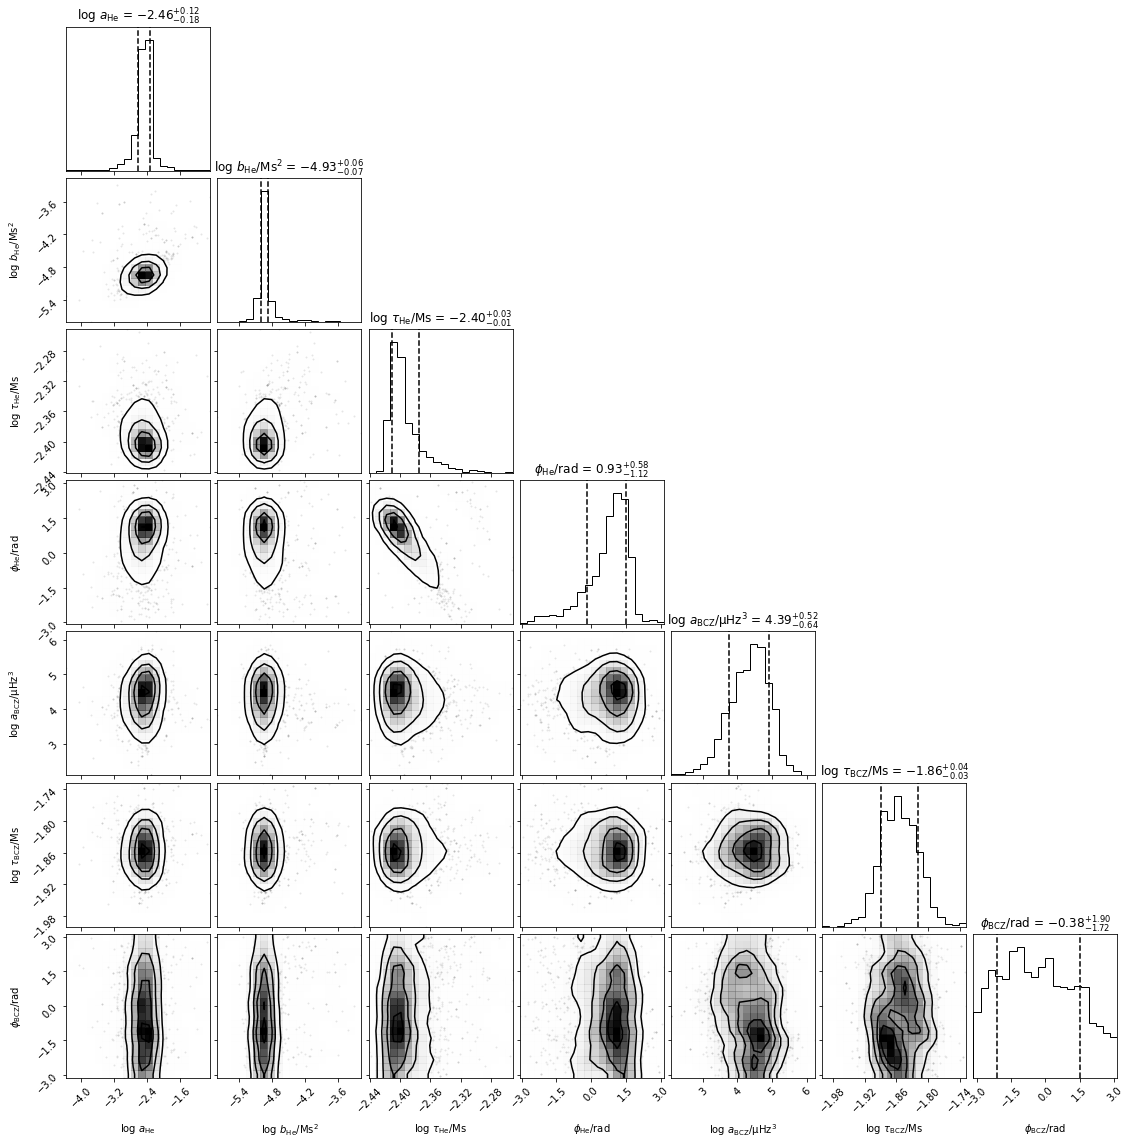

In [58]:
ast.plot_corner(data, var_names=glitch_names);

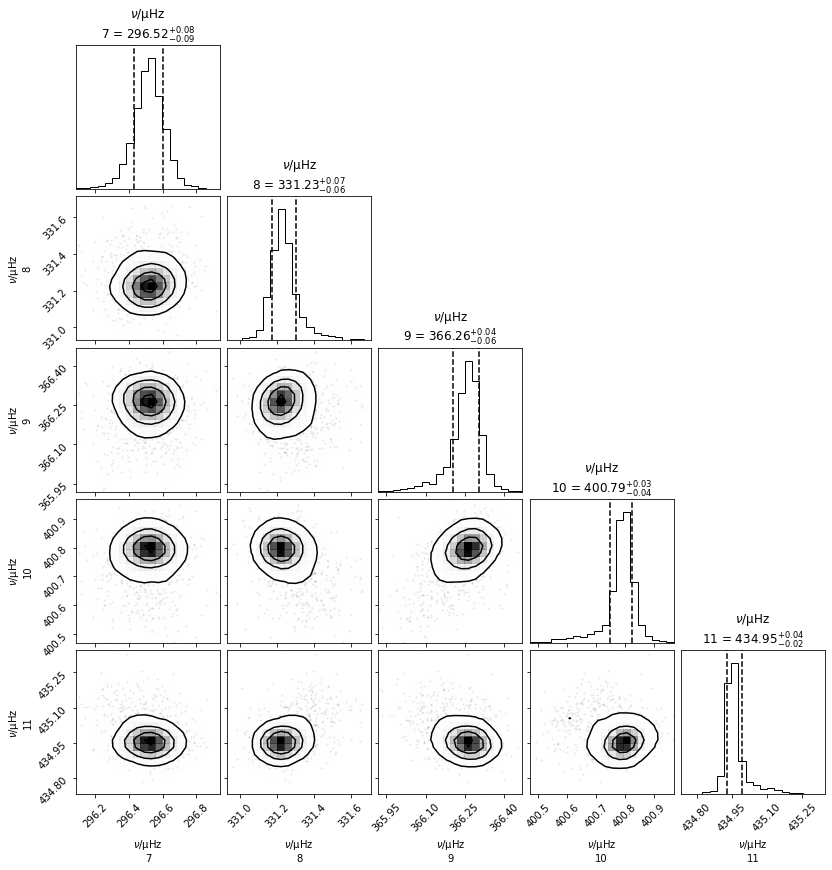

In [69]:
ast.plot_corner(data, group='posterior_predictive', var_names=['nu'], coords={'n': n[:5]});

In [66]:
ast.get_table(data, dims=())

,a_cz,a_he,b_he,delta_nu,epsilon,log_a_cz,log_a_he,log_b_he,log_tau_cz,log_tau_he,noise,phi_cz,phi_he,tau_cz,tau_he
metric,,,,,,,,,,,,,,,
mean,45900.0,0.0040,0.000016,35.289,1.344,4.33,-2.481,-4.907,-1.8541,-2.3927,0.0282,-0.30,0.69,0.01404,0.004055
sd,74900.0,0.0055,0.000029,0.203,0.100,0.58,0.245,0.199,0.0353,0.0242,0.0336,1.61,0.96,0.00115,0.000240
16th,5500.0,0.0023,0.000010,35.101,1.246,3.74,-2.634,-5.004,-1.8888,-2.4112,0.0035,-2.10,-0.19,0.01292,0.003879
50th,24300.0,0.0035,0.000012,35.283,1.345,4.39,-2.457,-4.933,-1.8552,-2.3995,0.0137,-0.38,0.93,0.01396,0.003986
84th,81300.0,0.0046,0.000013,35.482,1.447,4.91,-2.335,-4.872,-1.8183,-2.3745,0.0603,1.52,1.51,0.01519,0.004222


In [67]:
data.to_netcdf('data/obs_inference_data.nc')

'data/obs_inference_data.nc'